<a href="https://colab.research.google.com/github/geraldgong/Kaggle_shopee/blob/gong/shopee_embedding_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import gc
import pickle
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())
import cudf, cuml, cupy, cupyx

In [70]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
SEED = 100
BATCH_SIZE =128
CHUNK_SIZE = 2048
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


# Load Data

In [ ]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
#     image /= 255  # normalize to [0,1] rangeI'm not a 
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def augmentation(ds):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.3),
#         layers.experimental.preprocessing.RandomTranslation(
#             height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
#         layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
    ])
    
    # Batch all datasets
    ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set
    ds = ds.map(lambda x: data_augmentation(x))

    # Prefecting on all datasets
    return ds.prefetch(1)

def prepare_data(df, augment=False):
    # Load images
    path_ds = tf.data.Dataset.from_tensor_slices(df['image_paths'])
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

    if augment:
        ds = augmentation(image_ds)
    else:
        ds = image_ds.batch(BATCH_SIZE).prefetch(1)
    
    return ds

In [ ]:
tf.random.set_seed(SEED)
load_dir = os.getcwd() + '/data' #'/kaggle/input/ranzcr-clip-catheter-line-classification'

# Load and process images
df_train = pd.read_csv('./data/train.csv')
df_train['image_paths'] = load_dir + '/train_images/' + df_train['image'] 

df_test = pd.read_csv('./data/test.csv')
df_test['image_paths'] = load_dir + '/test_images/' + df_test['image'] 

train_ds = prepare_data(df_train, augment=False)
test_ds = prepare_data(df_test, augment=False)

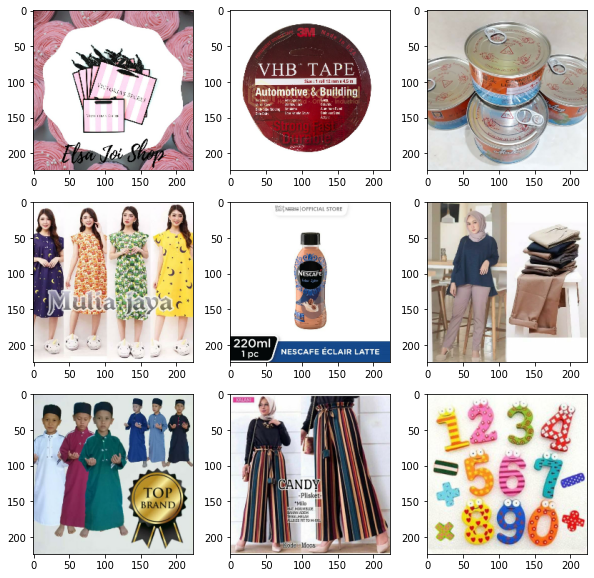

In [ ]:
plt.figure(figsize=(10, 10))
for i, image_path, in enumerate(df_train['image_paths'][:9]):
    plt.subplot(3, 3, i + 1)
    image = tf.io.read_file(image_path)
    image = preprocess_image(image) / 255
    plt.imshow(image)
plt.show()

## Train ground truth

In [ ]:
%memit
tmp = df_train.groupby('label_group').posting_id.agg('unique').to_dict()
df_train['target'] = df_train.label_group.map(tmp)
%memit

peak memory: 344.65 MiB, increment: -0.01 MiB
peak memory: 350.57 MiB, increment: 0.00 MiB


In [ ]:
df_train.head()

,posting_id,image,image_phash,title,label_group,image_paths,target
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,/Users/ygong/Side_Projects/Kaggle_shopee/data/...,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,/Users/ygong/Side_Projects/Kaggle_shopee/data/...,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,/Users/ygong/Side_Projects/Kaggle_shopee/data/...,"[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,/Users/ygong/Side_Projects/Kaggle_shopee/data/...,"[train_2406599165, train_3342059966]"
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,/Users/ygong/Side_Projects/Kaggle_shopee/data/...,"[train_3369186413, train_921438619]"


# Image embedding

In [ ]:
%memit
model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=None)
%memit

peak memory: 352.74 MiB, increment: 0.00 MiB
peak memory: 415.01 MiB, increment: 0.00 MiB


In [ ]:
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [ ]:
%memit
train_embeddings_image = model.predict(train_ds, verbose=1)
del model
_ = gc.collect()
%memit

peak memory: 5922.19 MiB, increment: 0.00 MiB
268/268 [==============================] - 743s 3s/step
peak memory: 4180.80 MiB, increment: 0.18 MiB


In [ ]:
# Save data
with open('./data/image_embeddings.pkl', 'wb') as f:
    pickle.dump(train_embeddings_image, f)

In [ ]:
%memit
# Load data
with open('./data/image_embeddings.pkl', 'rb') as f:
    train_embeddings_image = pickle.load(f)
%memit

peak memory: 415.02 MiB, increment: 0.00 MiB
peak memory: 582.29 MiB, increment: 0.01 MiB


## K-Nearest Neighbors

In [ ]:
%memit
knn = NearestNeighbors(n_neighbors=50)
knn.fit(train_embeddings_image)
%memit

peak memory: 582.39 MiB, increment: 0.00 MiB
peak memory: 582.39 MiB, increment: 0.00 MiB


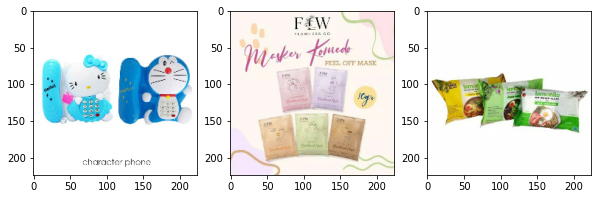

In [ ]:
plt.figure(figsize=(10, 4))
for i, image_path, in enumerate(df_test['image_paths'][:3]):
    plt.subplot(1, 3, i + 1)
    image = tf.io.read_file(image_path)
    image = preprocess_image(image)/255
    plt.imshow(image)
plt.show()

In [ ]:
%memit
dist, idx = knn.kneighbors(train_embeddings_image)
counts = (dist < 7).sum(axis=1)
image_index = [idx[i, :counts[i]].tolist() for i in range(len(df_train))]
del train_embeddings_image, dist, idx, counts
gc.collect()
%memit

peak memory: 582.40 MiB, increment: 0.00 MiB
peak memory: 1484.00 MiB, increment: -0.25 MiB


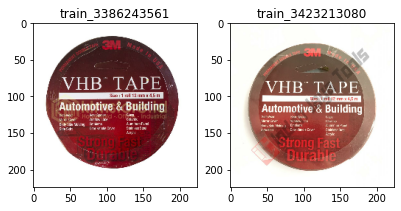

In [ ]:
plt.figure(figsize=(10, 4))
for i, image_path, in enumerate(df_train[df_train.posting_id.isin(
    df_train['target'][1])]['image_paths'][:3]):
    plt.subplot(1, 3, i + 1)
    plt.title(df_train['target'][1][i])
    image = tf.io.read_file(image_path)
    image = preprocess_image(image) / 255
    plt.imshow(image)
plt.show()

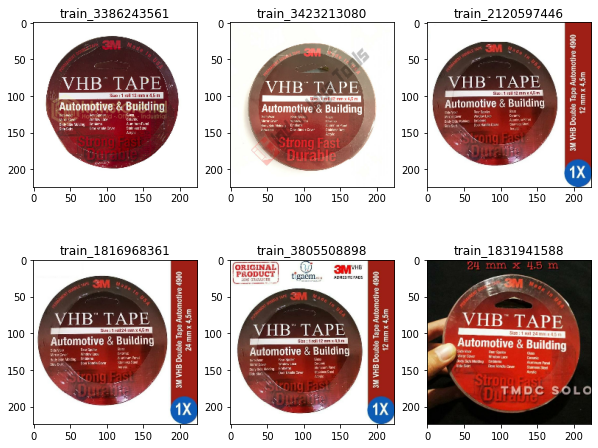

In [ ]:
plt.figure(figsize=(10, 8))
for i, image_path, in enumerate(df_train['image_paths'][idx[1,:]][:6]):
    plt.subplot(2, 3, i + 1)
    plt.title(df_train['posting_id'][idx[1,:]].tolist()[i])
    image = tf.io.read_file(image_path)
    image = preprocess_image(image) / 255
    plt.imshow(image)
plt.show()

# Text Embedding

In [ ]:
%memit
model_text = TfidfVectorizer(binary=True, max_features=25000)
text_embeddings = model_text.fit_transform(df_train.title).toarray()
# convert to sparse matrix
text_embeddings = sparse.csr_matrix(text_embeddings)
%memit

peak memory: 2505.47 MiB, increment: 0.00 MiB
peak memory: 2505.47 MiB, increment: 0.00 MiB


In [ ]:
def cos_sim(A, B):
    num = np.dot(A, B.T)
    p1 = np.sqrt(np.sum(A.power(2), axis=1))
    p2 = np.sqrt(np.sum(B.power(2), axis=1)).T

    return num / (p1 * p2)

In [ ]:
%memit
text_index = []
for i in range(int(np.ceil(len(df_train) / CHUNK_SIZE))):
    start_idx = i * CHUNK_SIZE
    end_idx = min((i + 1) * CHUNK_SIZE, len(df_train))
    print('Chunk', start_idx, 'to', end_idx)

    sim_chunk = cos_sim(text_embeddings, text_embeddings[start_idx:end_idx, :]).T
    r, c = np.where(sim_chunk > 0.7)
    text_index += np.split(c, np.flatnonzero(r[1:] != r[:-1])+1)

del sim_chunk, r, c, text_embeddings
_= gc.collect()
%memit

peak memory: 2505.50 MiB, increment: 0.00 MiB
Chunk 0 to 4096
Chunk 4096 to 8192
Chunk 8192 to 12288
Chunk 12288 to 16384
Chunk 16384 to 20480
Chunk 20480 to 24576
Chunk 24576 to 28672
Chunk 28672 to 32768
Chunk 32768 to 34250
peak memory: 2505.95 MiB, increment: -0.08 MiB


# Evaluation

In [ ]:
%memit
df_train['matches'] = [
    ' '.join(set(df_train['posting_id'][text].tolist() + df_train['posting_id'][image].tolist()))
    for text, image in zip(text_index, image_index)
]
%memit

peak memory: 2506.65 MiB, increment: 0.00 MiB
peak memory: 2506.68 MiB, increment: 0.00 MiB


In [ ]:
def row_wise_f1_score(y_true, y_pred):

    y_true = y_true.apply(lambda x: set(x))
    y_pred = y_pred.apply(lambda x: set(x.split()))

    tp = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    fp = y_pred.apply(lambda x: len(x)).values - tp
    fn = y_true.apply(lambda x: len(x)).values - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * ((precision * recall) / (precision + recall))
    return f1

df_train['f1'] = row_wise_f1_score(df_train['target'], df_train['matches'])
df_train['f1'].mean()

0.72503026259278

# Submission

In [ ]:
df_submit = pd.read_csv('./data/sample_submission.csv')
df_submit

,posting_id,matches
0,test_2255846744,test_2255846744
1,test_3588702337,test_3588702337
2,test_4015706929,test_4015706929


In [ ]:
df_submit.to_csv('submission.csv', index=False)

,posting_id,matches
0,test_2255846744,test_2255846744 test_4015706929 test_3588702337
1,test_3588702337,test_3588702337 test_4015706929 test_2255846744
2,test_4015706929,test_4015706929 test_2255846744 test_3588702337
